# Point cloud classification with PointNet


# Point cloud classification

## Introduction

This project applies the PointNet architecture to the Toronto-3D dataset for semantic segmentation of outdoor LiDAR point clouds. Unlike indoor datasets, Toronto-3D presents challenges like large-scale scans, diverse object classes, and varying densities. We process .ply files, sample point blocks, train PointNet to classify each point, and visualize predictions to evaluate model performance in urban outdoor scenes.

## Setup

If using colab first install laspy with `!pip install laspy`.

In [12]:
!pip install laspy



### Environment Setup and Library Imports

In [13]:
import os
import glob
import zipfile
import numpy as np
import laspy
from tensorflow import data as tf_data
from keras import ops
import keras
from keras import layers
from matplotlib import pyplot as plt

keras.utils.set_random_seed(seed=42)

## Load dataset

1.Upload toronto3d.zip manually in Colab, then unzip it

2.Upload ZIP file

In [14]:
# Upload toronto3d.zip manually in Colab, then unzip it
from google.colab import files

# Upload ZIP file
print("Upload your 'toronto3d.zip' file now...")
uploaded = files.upload()

Upload your 'toronto3d.zip' file now...


Saving Toronto_3D.zip to Toronto_3D (1).zip


3.Unzip Uploaded Toronto_3D.zip

In [16]:
import zipfile

zip_path = "Toronto_3D.zip"
extract_path = "/content/Toronto3D"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

DATA_DIR = extract_path
print("DATA_DIR is set to:", DATA_DIR)


DATA_DIR is set to: /content/Toronto3D


## Read and Visualize

In [17]:
import os

# Recursively list all files and folders in DATA_DIR
for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        print(os.path.join(root, file))


/content/Toronto3D/Toronto_3D/L001.ply
/content/Toronto3D/Toronto_3D/Colors.xml
/content/Toronto3D/Toronto_3D/L002.ply
/content/Toronto3D/Toronto_3D/Mavericks_classes_9.txt


In [18]:
!pip install open3d

import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt


### Load and Visualize a .ply File

In [19]:
# Load PLY file
ply_path = "/content/Toronto3D/Toronto_3D/L001.ply"
pcd = o3d.io.read_point_cloud(ply_path)

# Print info
print(pcd)
print("Number of points:", np.asarray(pcd.points).shape[0])

# Visualize
o3d.visualization.draw_geometries([pcd])


PointCloud with 21567172 points.
Number of points: 21567172
[Open3D WARNING] GLFW Error: Failed to detect any supported platform
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


### Matplotlib for 3D Scatter Plot

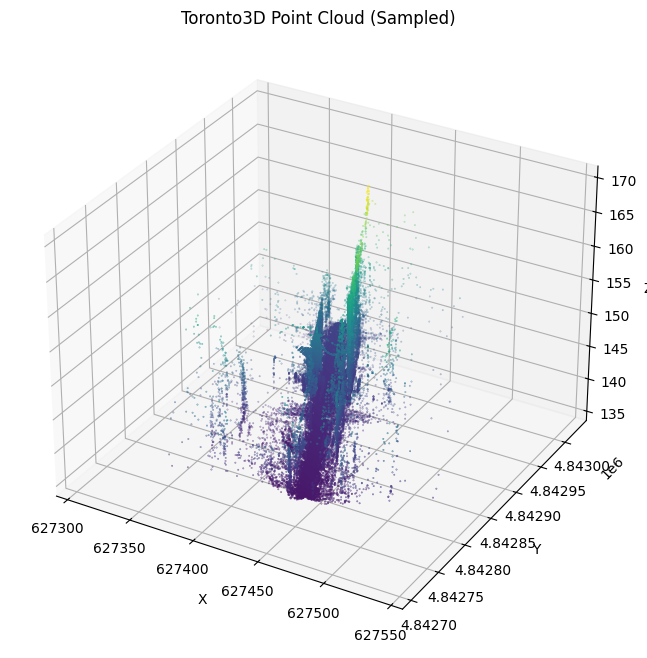

In [20]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

# Load point cloud
ply_path = "/content/Toronto3D/Toronto_3D/L001.ply"
pcd = o3d.io.read_point_cloud(ply_path)

# Convert to numpy
points = np.asarray(pcd.points)

# Optional: subsample for visualization
sample_size = 100_000
indices = np.random.choice(points.shape[0], size=min(sample_size, points.shape[0]), replace=False)
sampled_points = points[indices]

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2],
           s=0.1, c=sampled_points[:, 2], cmap='viridis')
ax.set_title("Toronto3D Point Cloud (Sampled)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()


## Build a Model

In [25]:
import tensorflow as tf
from keras import layers, Model

def pointnet_segmentation_model(num_points=4096, num_classes=9):
    inputs = layers.Input(shape=(num_points, 3))  # XYZ only, extend if needed

    # Input Transformation Net
    x = layers.Conv1D(64, 1, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(128, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(1024, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalMaxPooling1D()(x)

    # Feature Transform Net (could be added for regularization)
    global_feature = layers.Dense(512, activation='relu')(x)
    global_feature = layers.BatchNormalization()(global_feature)
    global_feature = layers.Dense(256, activation='relu')(global_feature)
    global_feature = layers.BatchNormalization()(global_feature)

    # Repeat global features
    global_feature = layers.RepeatVector(num_points)(global_feature)
    global_feature = layers.Concatenate()([inputs, global_feature])

    # Segmentation MLP
    x = layers.Conv1D(256, 1, activation='relu')(global_feature)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(128, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(num_classes, 1)(x)  # No activation for logits

    outputs = layers.Softmax()(x)  # Per-point class probabilities

    return Model(inputs=inputs, outputs=outputs)

# Create model
model = pointnet_segmentation_model()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 4096, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 4096, 64)  │        256 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4096, 64)  │        256 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 4096, 128) │      8,320 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4096, 128) │        512 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 4096,      │    132,096 │ batch_normalizat… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4096,      │      4,096 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 1024)      │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    524,800 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    131,328 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 4096, 256) │          0 │ batch_normalizat… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4096, 259) │          0 │ input_layer_1[0]… │
│ (Concatenate)       │                   │            │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 4096, 256) │     66,560 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4096, 256) │      1,024 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 4096, 128) │     32,896 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4096, 128) │        512 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 4096, 9)   │      1,161 │ batch_normalizat

 Total params: 906,889 (3.46 MB)

 Trainable params: 902,153 (3.44 MB)

 Non-trainable params: 4,736 (18.50 KB)

In [26]:
!pip install plyfile


In [28]:
from plyfile import PlyData

ply_path = "/content/Toronto3D/Toronto_3D/L001.ply"
plydata = PlyData.read(ply_path)

print(plydata['vertex'].data.dtype.names)



('x', 'y', 'z', 'red', 'green', 'blue', 'scalar_Intensity', 'scalar_GPSTime', 'scalar_ScanAngleRank', 'scalar_Label')


In [29]:
labels = np.array(plydata['vertex']['scalar_Label'])
print("Labels shape:", labels.shape)
print("Sample labels:", labels[:20])


Labels shape: (21567172,)
Sample labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### Build the data generator with block sampling

In [30]:
import numpy as np
from plyfile import PlyData

def load_ply_with_labels(ply_path):
    plydata = PlyData.read(ply_path)
    points = np.vstack([
        plydata['vertex']['x'],
        plydata['vertex']['y'],
        plydata['vertex']['z'],
    ]).T
    labels = np.array(plydata['vertex']['scalar_Label']).astype(int)
    return points, labels

def sample_block(points, labels, block_size=4096):
    N = points.shape[0]
    if N < block_size:
        idxs = np.random.choice(N, block_size, replace=True)
    else:
        idxs = np.random.choice(N, block_size, replace=False)
    return points[idxs], labels[idxs]

def data_generator(ply_files, batch_size=8, block_size=4096):
    while True:
        batch_points = []
        batch_labels = []
        for _ in range(batch_size):
            ply_path = np.random.choice(ply_files)
            points, labels = load_ply_with_labels(ply_path)
            block_points, block_labels = sample_block(points, labels, block_size)
            batch_points.append(block_points)
            batch_labels.append(block_labels)
        yield np.array(batch_points), np.array(batch_labels)



### Compile PointNet model

In [31]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


### Start training

In [32]:
ply_files = [
    "/content/Toronto3D/Toronto_3D/L001.ply",
    "/content/Toronto3D/Toronto_3D/L002.ply"
]

batch_size = 8
block_size = 4096

train_gen = data_generator(ply_files, batch_size=batch_size, block_size=block_size)

model.fit(
    train_gen,
    steps_per_epoch=50,
    epochs=10
)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 683s 14s/step - accuracy: 0.2350 - loss: 2.2757
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 730s 15s/step - accuracy: 0.5316 - loss: 1.5471
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 714s 14s/step - accuracy: 0.6694 - loss: 1.2442
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 724s 15s/step - accuracy: 0.6941 - loss: 1.1087
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 719s 14s/step - accuracy: 0.6965 - loss: 1.0338
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 708s 14s/step - accuracy: 0.7180 - loss: 1.0049
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 692s 14s/step - accuracy: 0.6881 - loss: 1.0630
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 702s 14s/step - accuracy: 0.6938 - loss: 1.0328
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 697s 14s/step - accuracy: 0.7213 - loss: 0.9590
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 683s 14s/step - accuracy: 0.7259 - loss: 0.9345


### Predict and Visualize Point Labels

In [33]:
# Load a full point cloud
test_ply = "/content/Toronto3D/Toronto_3D/L001.ply"
points, true_labels = load_ply_with_labels(test_ply)

# Sample a block for prediction
block_points, block_labels = sample_block(points, true_labels, block_size=4096)
block_points_input = np.expand_dims(block_points, axis=0)  # (1, 4096, 3)


In [34]:
pred_logits = model.predict(block_points_input)  # (1, 4096, num_classes)
pred_labels = np.argmax(pred_logits, axis=-1)[0]  # (4096,)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


### Predicted labels

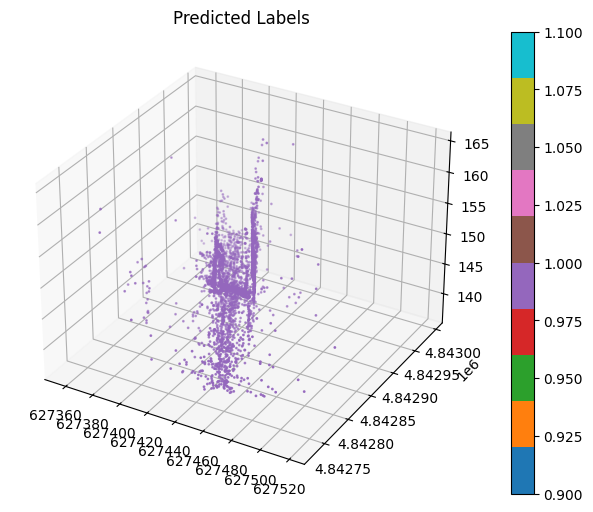

In [37]:
from mpl_toolkits.mplot3d import Axes3D

def plot_point_cloud(points, labels, title="Point Cloud"):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=labels, cmap="tab10", s=1)
    ax.set_title(title)
    plt.colorbar(scatter, ax=ax)
    plt.show()

plot_point_cloud(block_points, pred_labels, title="Predicted Labels")


### Prediction vs Ground Truth

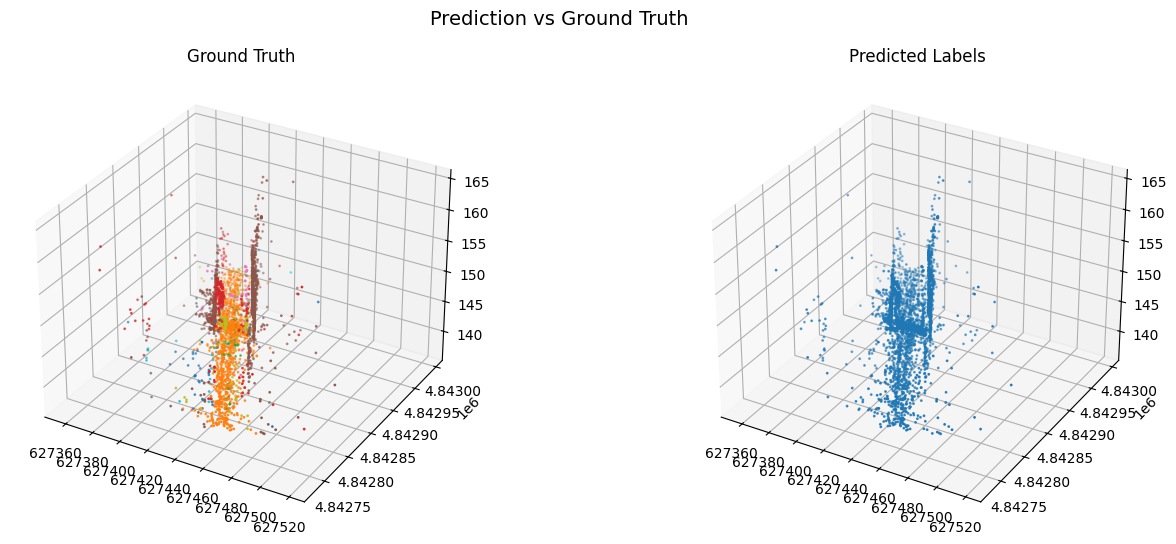

In [38]:
def plot_true_vs_pred(points, true_labels, pred_labels, title="Prediction vs Ground Truth"):
    fig = plt.figure(figsize=(16, 6))

    # Ground Truth
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(points[:, 0], points[:, 1], points[:, 2],
                c=true_labels, cmap='tab10', s=1)
    ax1.set_title("Ground Truth")

    # Prediction
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(points[:, 0], points[:, 1], points[:, 2],
                c=pred_labels, cmap='tab10', s=1)
    ax2.set_title("Predicted Labels")

    plt.suptitle(title, fontsize=14)
    plt.show()

plot_true_vs_pred(block_points, block_labels, pred_labels)


### Color with Class Legend

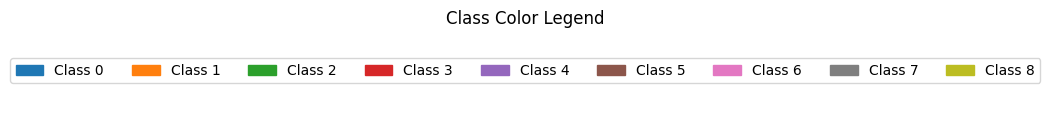

In [39]:
def show_colormap_legend(num_classes=9):
    import matplotlib.patches as mpatches
    cmap = plt.get_cmap('tab10')
    legend = [mpatches.Patch(color=cmap(i), label=f"Class {i}") for i in range(num_classes)]
    plt.figure(figsize=(8, 1))
    plt.legend(handles=legend, ncol=num_classes, loc='center')
    plt.axis('off')
    plt.title("Class Color Legend")
    plt.show()

show_colormap_legend()


### Per-Class Accuracy (Confusion Matrix)

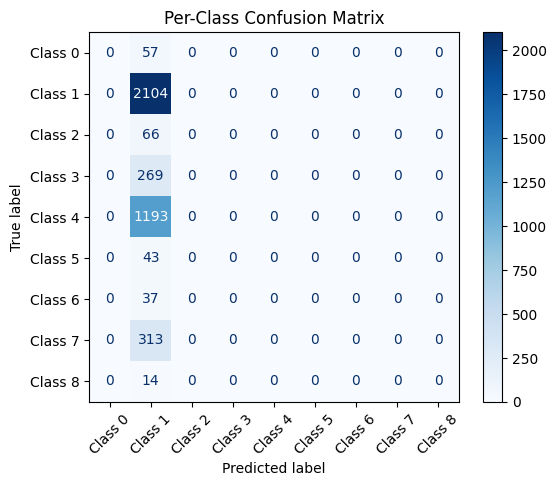

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(block_labels, pred_labels, labels=np.arange(9))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(9)])
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Per-Class Confusion Matrix")
plt.show()
